## Figure 2(a)

处理SLAB方案数据...
SLAB云量数据形状: (115, 155)
处理Noah-MP方案数据...
Noah-MP云量数据形状: (115, 155)
处理RUC方案数据...
RUC云量数据形状: (115, 155)
处理MODIS云量数据并插值到WRF网格...
找到 6 个MODIS文件
插值后MODIS云量数据形状: (115, 155)
开始绘制云量分布图...


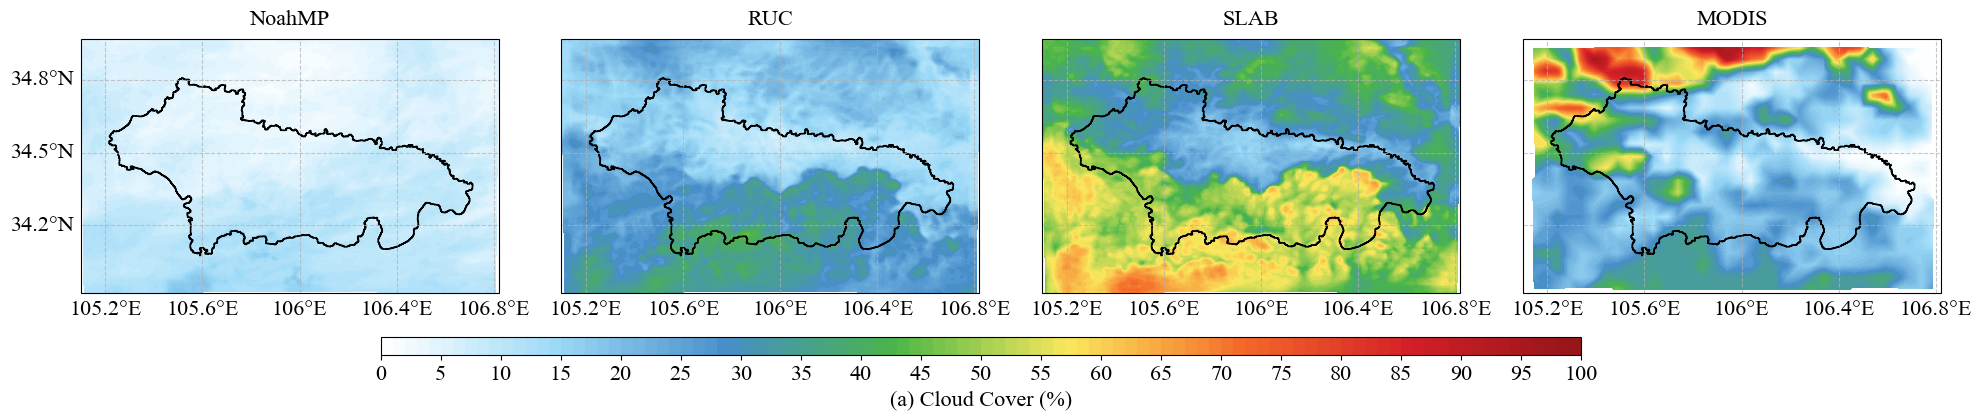

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import cmaps
from cartopy.io.shapereader import Reader
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import warnings
from pyhdf.SD import SD, SDC
from scipy.interpolate import griddata
from matplotlib.ticker import MaxNLocator

# ========================
# 0. 设置字体
# ========================
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']  # 英文新罗马
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.size'] = 12
warnings.filterwarnings("ignore", category=UserWarning, module="netCDF4")

# ========================
# 1. 加载地理边界数据
# ========================
tianshui_shp = Reader('/Raid_38TB/wangying/zhouyy2023/notebook_directory/Tianshui_geo/z.shp')

# ========================
# 2. 处理WRF模拟数据（替换为云量相关变量）
# ========================
def process_wrf_data(filepath):
    """处理WRF数据，提取云量变量"""
    ds = nc.Dataset(filepath)
    
    # 根据实际变量名读取'CLDFRA'
    cldfra = ds.variables['CLDFRA']  # 实际的云量变量名
    total_cloud = np.max(cldfra, axis=1)
    cloud_sampled = total_cloud[24:, :, :]  # 从第24个时次开始
    mean_cloud = np.nanmean(cloud_sampled, axis=0) * 100  # 转换为百分比
    
    lon = ds.variables['XLONG'][0]
    lat = ds.variables['XLAT'][0]
    return mean_cloud, lat, lon

# 陆面方案数据处理
print("处理SLAB方案数据...")
cloud_slab, lat_slab, lon_slab = process_wrf_data('/Raid_38TB/wangying/zhouyy2023/WRF4.0_tianshui/WRF4.0/WRF/test/em_real_slab_MYNN_LH/wrfout_d03_2019-11-30_00:00:00')
print(f"SLAB云量数据形状: {cloud_slab.shape}")

print("处理Noah-MP方案数据...")
cloud_noahmp, lat_noahmp, lon_noahmp = process_wrf_data('/Raid_38TB/wangying/zhouyy2023/WRF4.0_tianshui/WRF4.0/WRF/test/em_real_noahmp_MYNN_LH/wrfout_d03_2019-11-30_00:00:00')
print(f"Noah-MP云量数据形状: {cloud_noahmp.shape}")

print("处理RUC方案数据...")
cloud_ruc, lat_ruc, lon_ruc = process_wrf_data("/Raid_38TB/wangying/zhouyy2023/WRF4.0_tianshui/WRF4.0/WRF/test/em_real_ruc_MYNN_LH/wrfout_d03_2019-11-30_00:00:00")
print(f"RUC云量数据形状: {cloud_ruc.shape}")

# ========================
# 3. 处理MODIS云量数据
# ========================
def process_modis_cloud_data(folder, wrf_lat, wrf_lon):
    """处理MODIS云量数据并插值到WRF网格"""
    modis_files = [f for f in os.listdir(folder) if f.endswith('.hdf')]
    if not modis_files:
        raise FileNotFoundError(f"在文件夹 {folder} 中未找到MODIS HDF文件")
    
    print(f"找到 {len(modis_files)} 个MODIS文件")
    
    # 计算WRF区域在MODIS中的索引范围
    lat_min, lat_max = np.min(wrf_lat), np.max(wrf_lat)
    lon_min, lon_max = np.min(wrf_lon), np.max(wrf_lon)
    
    # 初始化累加器
    cloud_accum = None
    count = None
    
    for file in modis_files:
        try:
            filepath = os.path.join(folder, file)
            hdf = SD(filepath, SDC.READ)
            
            # 获取云量数据 - 使用指定的变量名
            cloud_data = hdf.select('Day_CMG_Cloud_Obscured')[:]
            
            # 创建经纬度网格 (MODIS 0.05°分辨率)
            modis_lats = np.linspace(90, -90, cloud_data.shape[0])
            modis_lons = np.linspace(-180, 180, cloud_data.shape[1])
            
            # 创建掩码选择研究区域
            lat_mask = (modis_lats >= lat_min) & (modis_lats <= lat_max)
            lon_mask = (modis_lons >= lon_min) & (modis_lons <= lon_max)
            
            # 截取研究区域
            region_cloud = cloud_data[lat_mask, :][:, lon_mask]
            region_lats = modis_lats[lat_mask]
            region_lons = modis_lons[lon_mask]
            
            # 创建有效数据掩码 (0-100为有效云量值)
            valid_mask = (region_cloud >= 0) & (region_cloud <= 100)
            
            # 初始化累加器
            if cloud_accum is None:
                cloud_accum = np.zeros_like(region_cloud, dtype=np.float32)
                count = np.zeros_like(region_cloud, dtype=np.int32)
            
            # 累加有效数据
            cloud_accum[valid_mask] += region_cloud[valid_mask]
            count[valid_mask] += 1
            
            hdf.end()
        except Exception as e:
            print(f"处理文件 {file} 时出错: {e}")
            continue
    
    # 计算平均值
    mean_cloud = np.full_like(cloud_accum, np.nan)
    valid_points = count > 0
    mean_cloud[valid_points] = cloud_accum[valid_points] / count[valid_points]
    
    # 创建MODIS网格坐标
    lon_grid, lat_grid = np.meshgrid(region_lons, region_lats)
    
    # 将MODIS数据插值到WRF网格
    points = np.column_stack((lon_grid.flatten(), lat_grid.flatten()))
    values = mean_cloud.flatten()
    wrf_points = np.column_stack((wrf_lon.flatten(), wrf_lat.flatten()))
    
    # 使用线性插值
    modis_on_wrf_grid = griddata(
        points, 
        values, 
        wrf_points, 
        method='linear',
        fill_value=np.nan
    )
    
    # 重塑为WRF网格形状
    modis_on_wrf_grid = modis_on_wrf_grid.reshape(wrf_lat.shape)
    
    return modis_on_wrf_grid, wrf_lat, wrf_lon

print("处理MODIS云量数据并插值到WRF网格...")
modis_cloud, modis_lat, modis_lon = process_modis_cloud_data(
    "/Raid_38TB/wangying/zhouyy2023/DATA/MYD10C1", 
    lat_ruc,  # 使用RUC方案的经纬度作为参考
    lon_ruc
)
print(f"插值后MODIS云量数据形状: {modis_cloud.shape}")

# ========================
# 4. 绘制云量分布图
# ========================
print("开始绘制云量分布图...")
# 创建1行4列的子图（修改为4列）
fig, axs = plt.subplots(1, 4, figsize=(24, 6), 
                       subplot_kw={'projection': ccrs.PlateCarree()})

# 调整布局
plt.subplots_adjust(bottom=0.15, wspace=0.15, hspace=0.1)

# 设置云量颜色范围和色标
cloud_levels = np.arange(0, 101, 1)  # 5%间隔 (0-100%)
cloud_cmap = cmaps.WhiteBlueGreenYellowRed  # 使用蓝白色系表示云量

# 更新标题和数据集列表
titles = ['NoahMP', 'RUC', 'SLAB', 'MODIS']
datasets = [cloud_noahmp, cloud_ruc, cloud_slab, modis_cloud]
lons = [lon_slab, lon_noahmp, lon_ruc, lon_ruc]  # MODIS使用WRF的经纬度
lats = [lat_slab, lat_noahmp, lat_ruc, lat_ruc]

# 设置统一的地图范围
lon_min = min(np.min(lon_slab), np.min(lon_noahmp), np.min(lon_ruc))
lon_max = max(np.max(lon_slab), np.max(lon_noahmp), np.max(lon_ruc))
lat_min = min(np.min(lat_slab), np.min(lat_noahmp), np.min(lat_ruc))
lat_max = max(np.max(lat_slab), np.max(lat_noahmp), np.max(lat_ruc))

# 保存绘图对象用于色条
plots = []

for i, (ax, data, title) in enumerate(zip(axs, datasets, titles)):
    # 绘制云量填色图
    plot = ax.contourf(lons[i], lats[i], data, 
                      levels=cloud_levels, cmap=cloud_cmap, extend='neither')
    plots.append(plot)
    
    # 添加地理要素
    ax.add_geometries(tianshui_shp.geometries(), ccrs.PlateCarree(), 
                     facecolor='none', edgecolor='black', linewidth=1.2)
    ax.coastlines(resolution='10m', color='gray', linewidth=0.8)
    ax.set_title(title, fontsize=16, pad=10, loc='center')
    ax.set_extent([lon_min, lon_max, lat_min, lat_max])
    
    # 添加网格线
    gl = ax.gridlines(draw_labels=True, linestyle='--', alpha=0.7)
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LongitudeFormatter()
    gl.yformatter = LatitudeFormatter()
    gl.xlocator = MaxNLocator(nbins=5)
    gl.ylocator = MaxNLocator(nbins=4)
    gl.xlabel_style = {'size': 16}
    gl.ylabel_style = {'size': 16}
    
    # 只在左侧子图显示y轴标签
    if i != 0:
        gl.left_labels = False

# 创建共享的水平色条（位置调整为适应4列布局）
cax = fig.add_axes([0.25, 0.2, 0.5, 0.03])  # [left, bottom, width, height]
cbar = fig.colorbar(plots[0], cax=cax, orientation='horizontal')
cbar.ax.tick_params(labelsize=16)
cbar.set_label('(a) Cloud Cover (%)', fontsize=16)
cbar.set_ticks(np.arange(0, 101, 5))  # 每5%显示一个主刻度

# 保存结果
output_path = 'Cloud_Cover_Comparison.png'
#plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.show()

## Figure 2(b)

处理Noah-MP方案数据...
Noah-MP数据形状: (115, 155)
处理RUC方案数据...
RUC数据形状: (115, 155)
处理MODIS数据并插值到WRF网格(添加QA质量控制)...
找到 6 个MODIS文件
插值后MODIS数据形状: (115, 155)
开始绘图...
图形已保存为 'Snow_Cover_Comparison_3cols_QA_Controlled.png'


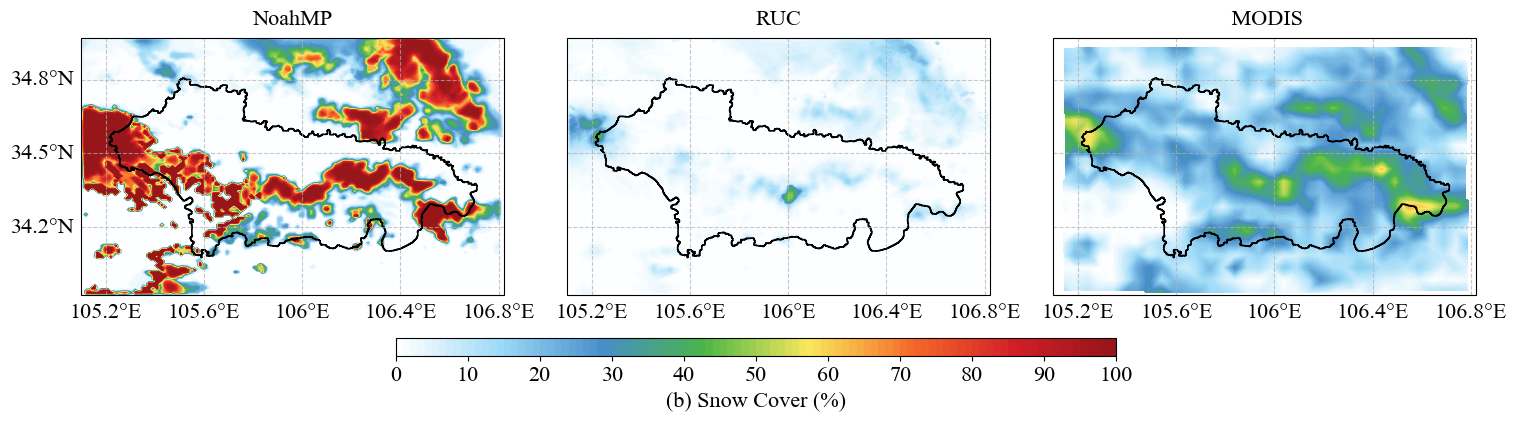

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import cmaps
from cartopy.io.shapereader import Reader
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import warnings
from pyhdf.SD import SD, SDC
from scipy.interpolate import griddata
from matplotlib.ticker import MaxNLocator

# ========================
# 0. 设置字体
# ========================、
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']  # 英文新罗马
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.size'] = 12
warnings.filterwarnings("ignore", category=UserWarning, module="netCDF4")

# ========================
# 1. 加载地理边界数据
# ========================
tianshui_shp = Reader('/Raid_38TB/wangying/zhouyy2023/notebook_directory/Tianshui_geo/z.shp')

# ========================
# 2. 处理WRF模拟数据
# ========================
def process_wrf_data(filepath):
    ds = nc.Dataset(filepath)
    snowc_var = ds.variables['SNOWC']
    snowc_sampled = snowc_var[24:, :, :]
    mean_snow = np.nanmean(snowc_sampled, axis=0) * 100
    lon = ds.variables['XLONG'][0]
    lat = ds.variables['XLAT'][0]
    return mean_snow, lat, lon

print("处理Noah-MP方案数据...")
snow_noahmp, _, _ = process_wrf_data('/Raid_38TB/wangying/zhouyy2023/WRF4.0_tianshui/WRF4.0/WRF/test/em_real_noahmp_MYNN_LH/wrfout_d03_2019-11-30_00:00:00')
print(f"Noah-MP数据形状: {snow_noahmp.shape}")

print("处理RUC方案数据...")
snow_ruc, lat, lon = process_wrf_data("/Raid_38TB/wangying/zhouyy2023/WRF4.0_tianshui/WRF4.0/WRF/test/em_real_ruc_MYNN_LH/wrfout_d03_2019-11-30_00:00:00")
print(f"RUC数据形状: {snow_ruc.shape}")

# ========================
# 3. 处理MODIS卫星数据 (添加QA质量控制)
# ========================
def process_modis_data(folder, wrf_lat, wrf_lon):
    """处理MODIS雪盖数据并插值到WRF网格，添加QA质量控制"""
    modis_files = [f for f in os.listdir(folder) if f.endswith('.hdf')]
    if not modis_files:
        raise FileNotFoundError(f"在文件夹 {folder} 中未找到MODIS HDF文件")
    
    print(f"找到 {len(modis_files)} 个MODIS文件")
    
    # 计算WRF区域在MODIS中的索引范围
    lat_min, lat_max = np.min(wrf_lat), np.max(wrf_lat)
    lon_min, lon_max = np.min(wrf_lon), np.max(wrf_lon)
    
    # 初始化累加器
    snow_accum = None
    count = None
    
    for file in modis_files:
        try:
            filepath = os.path.join(folder, file)
            hdf = SD(filepath, SDC.READ)
            
            # 获取全局数据
            snowcover = hdf.select('Day_CMG_Snow_Cover')[:]
            snow_qa = hdf.select('Snow_Spatial_QA')[:]  # 添加QA数据
            
            # 创建经纬度网格 (MODIS 0.05°分辨率)
            modis_lats = np.linspace(90, -90, snowcover.shape[0])
            modis_lons = np.linspace(-180, 180, snowcover.shape[1])
            
            # 创建掩码选择研究区域
            lat_mask = (modis_lats >= lat_min) & (modis_lats <= lat_max)
            lon_mask = (modis_lons >= lon_min) & (modis_lons <= lon_max)
            
            # 截取研究区域
            region_snow = snowcover[lat_mask, :][:, lon_mask]
            region_qa = snow_qa[lat_mask, :][:, lon_mask]  # 区域QA值
            region_lats = modis_lats[lat_mask]
            region_lons = modis_lons[lon_mask]
            
            # =========================================================
            # 关键修改：添加QA质量控制
            # QA值解释:
            # 0 = best, 1 = good, 2 = ok, 3 = poor, 4 = other
            # 252 = Antarctica mask, 253 = not mapped, 254 = no retrieval, 255 = fill
            # 只保留质量较好的数据 (0-2)
            # =========================================================
            qa_mask = (region_qa >= 0) & (region_qa <= 2)  # 只保留best/good/ok的质量数据
            
            # 创建有效数据掩码 (结合QA质量)
            valid_mask = (region_snow <= 100) & qa_mask
            
            # 初始化累加器
            if snow_accum is None:
                snow_accum = np.zeros_like(region_snow, dtype=np.float32)
                count = np.zeros_like(region_snow, dtype=np.int32)
            
            # 累加有效数据
            snow_accum[valid_mask] += region_snow[valid_mask]
            count[valid_mask] += 1
            
            hdf.end()
        except Exception as e:
            print(f"处理文件 {file} 时出错: {e}")
            continue
    
    # 计算平均值
    mean_snow = np.full_like(snow_accum, np.nan)
    valid_points = count > 0
    mean_snow[valid_points] = snow_accum[valid_points] / count[valid_points]
    
    # 创建MODIS网格坐标
    lon_grid, lat_grid = np.meshgrid(region_lons, region_lats)
    
    # 将MODIS数据插值到WRF网格
    points = np.column_stack((lon_grid.flatten(), lat_grid.flatten()))
    values = mean_snow.flatten()
    wrf_points = np.column_stack((wrf_lon.flatten(), wrf_lat.flatten()))
    
    # 使用线性插值并处理NaN值
    modis_on_wrf_grid = griddata(
        points, 
        values, 
        wrf_points, 
        method='linear',
        fill_value=np.nan
    )
    
    # 重塑为WRF网格形状
    modis_on_wrf_grid = modis_on_wrf_grid.reshape(wrf_lat.shape)
    
    return modis_on_wrf_grid, wrf_lat, wrf_lon

print("处理MODIS数据并插值到WRF网格(添加QA质量控制)...")
modis_snow, modis_lat, modis_lon = process_modis_data(
    "/Raid_38TB/wangying/zhouyy2023/DATA/MYD10C1", 
    lat, 
    lon
)
print(f"插值后MODIS数据形状: {modis_snow.shape}")

# ========================
# 4. 绘制结果（1行3列 + 底部水平色条）
# ========================
print("开始绘图...")
# 创建1行3列的子图，为底部色条留出空间
fig, axs = plt.subplots(1, 3, figsize=(18, 6), 
                       subplot_kw={'projection': ccrs.PlateCarree()})

# 调整布局 - 为底部色条留出空间
plt.subplots_adjust(bottom=0.15, wspace=0.15, hspace=0.1)

# 设置颜色范围和色标
snow_levels = np.arange(0, 101, 1)  # 1%间隔 (0-100)
snow_cmap = cmaps.WhiteBlueGreenYellowRed

titles = ['NoahMP', 'RUC', ' MODIS']
datasets = [snow_noahmp, snow_ruc, modis_snow]
lons = [lon, lon, lon]
lats = [lat, lat, lat]

# 设置统一的地图范围
lon_min, lon_max = np.min(lon), np.max(lon)
lat_min, lat_max = np.min(lat), np.max(lat)

# 保存绘图对象用于色条
plots = []

for i, (ax, data, title) in enumerate(zip(axs, datasets, titles)):
    # 使用contourf绘制（与第一个示例一致）
    plot = ax.contourf(lons[i], lats[i], data, 
                      levels=snow_levels, cmap=snow_cmap, extend='neither')
    plots.append(plot)  # 保存绘图对象用于色条
    
    # 添加地理要素
    ax.add_geometries(tianshui_shp.geometries(), ccrs.PlateCarree(), 
                     facecolor='none', edgecolor='black', linewidth=1.2)
    ax.coastlines(resolution='10m', color='gray', linewidth=0.8)
    ax.set_title(title, fontsize=16, pad=10, loc='center')
    ax.set_extent([lon_min, lon_max, lat_min, lat_max])
    
    # 添加网格线
    gl = ax.gridlines(draw_labels=True, linestyle='--', alpha=0.7)
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LongitudeFormatter()
    gl.yformatter = LatitudeFormatter()
    # 设置刻度数量
    gl.xlocator = MaxNLocator(nbins=5)  # x轴只显示5个刻度
    gl.ylocator = MaxNLocator(nbins=4)  # y轴只显示4个刻度
        
    # 设置刻度标签字体大小
    gl.xlabel_style = {'size': 16}  # 增大x轴刻度标签字体
    gl.ylabel_style = {'size': 16}  # 增大y轴刻度标签字体
    
    # 只在左侧子图显示y轴标签
    if i != 0:
        gl.left_labels = False

# 创建共享的水平色条（放置在底部）
cax = fig.add_axes([0.3, 0.2, 0.4, 0.03])  # [left, bottom, width, height]
cbar = fig.colorbar(plots[0], cax=cax, orientation='horizontal')
cbar.ax.tick_params(labelsize=16)  # 增大色条刻度标签字体
cbar.set_label('(b) Snow Cover (%)', fontsize=16)
cbar.set_ticks(np.arange(0, 101, 10))  # 每10%显示一个主刻度

output_path = 'Snow_Cover_Comparison_3cols_QA_Controlled.png'
#plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"图形已保存为 '{output_path}'")
plt.show()

## Figure 3

/tmp/ipykernel_249288/3802451417.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range("20191130", "20191208", freq="H")


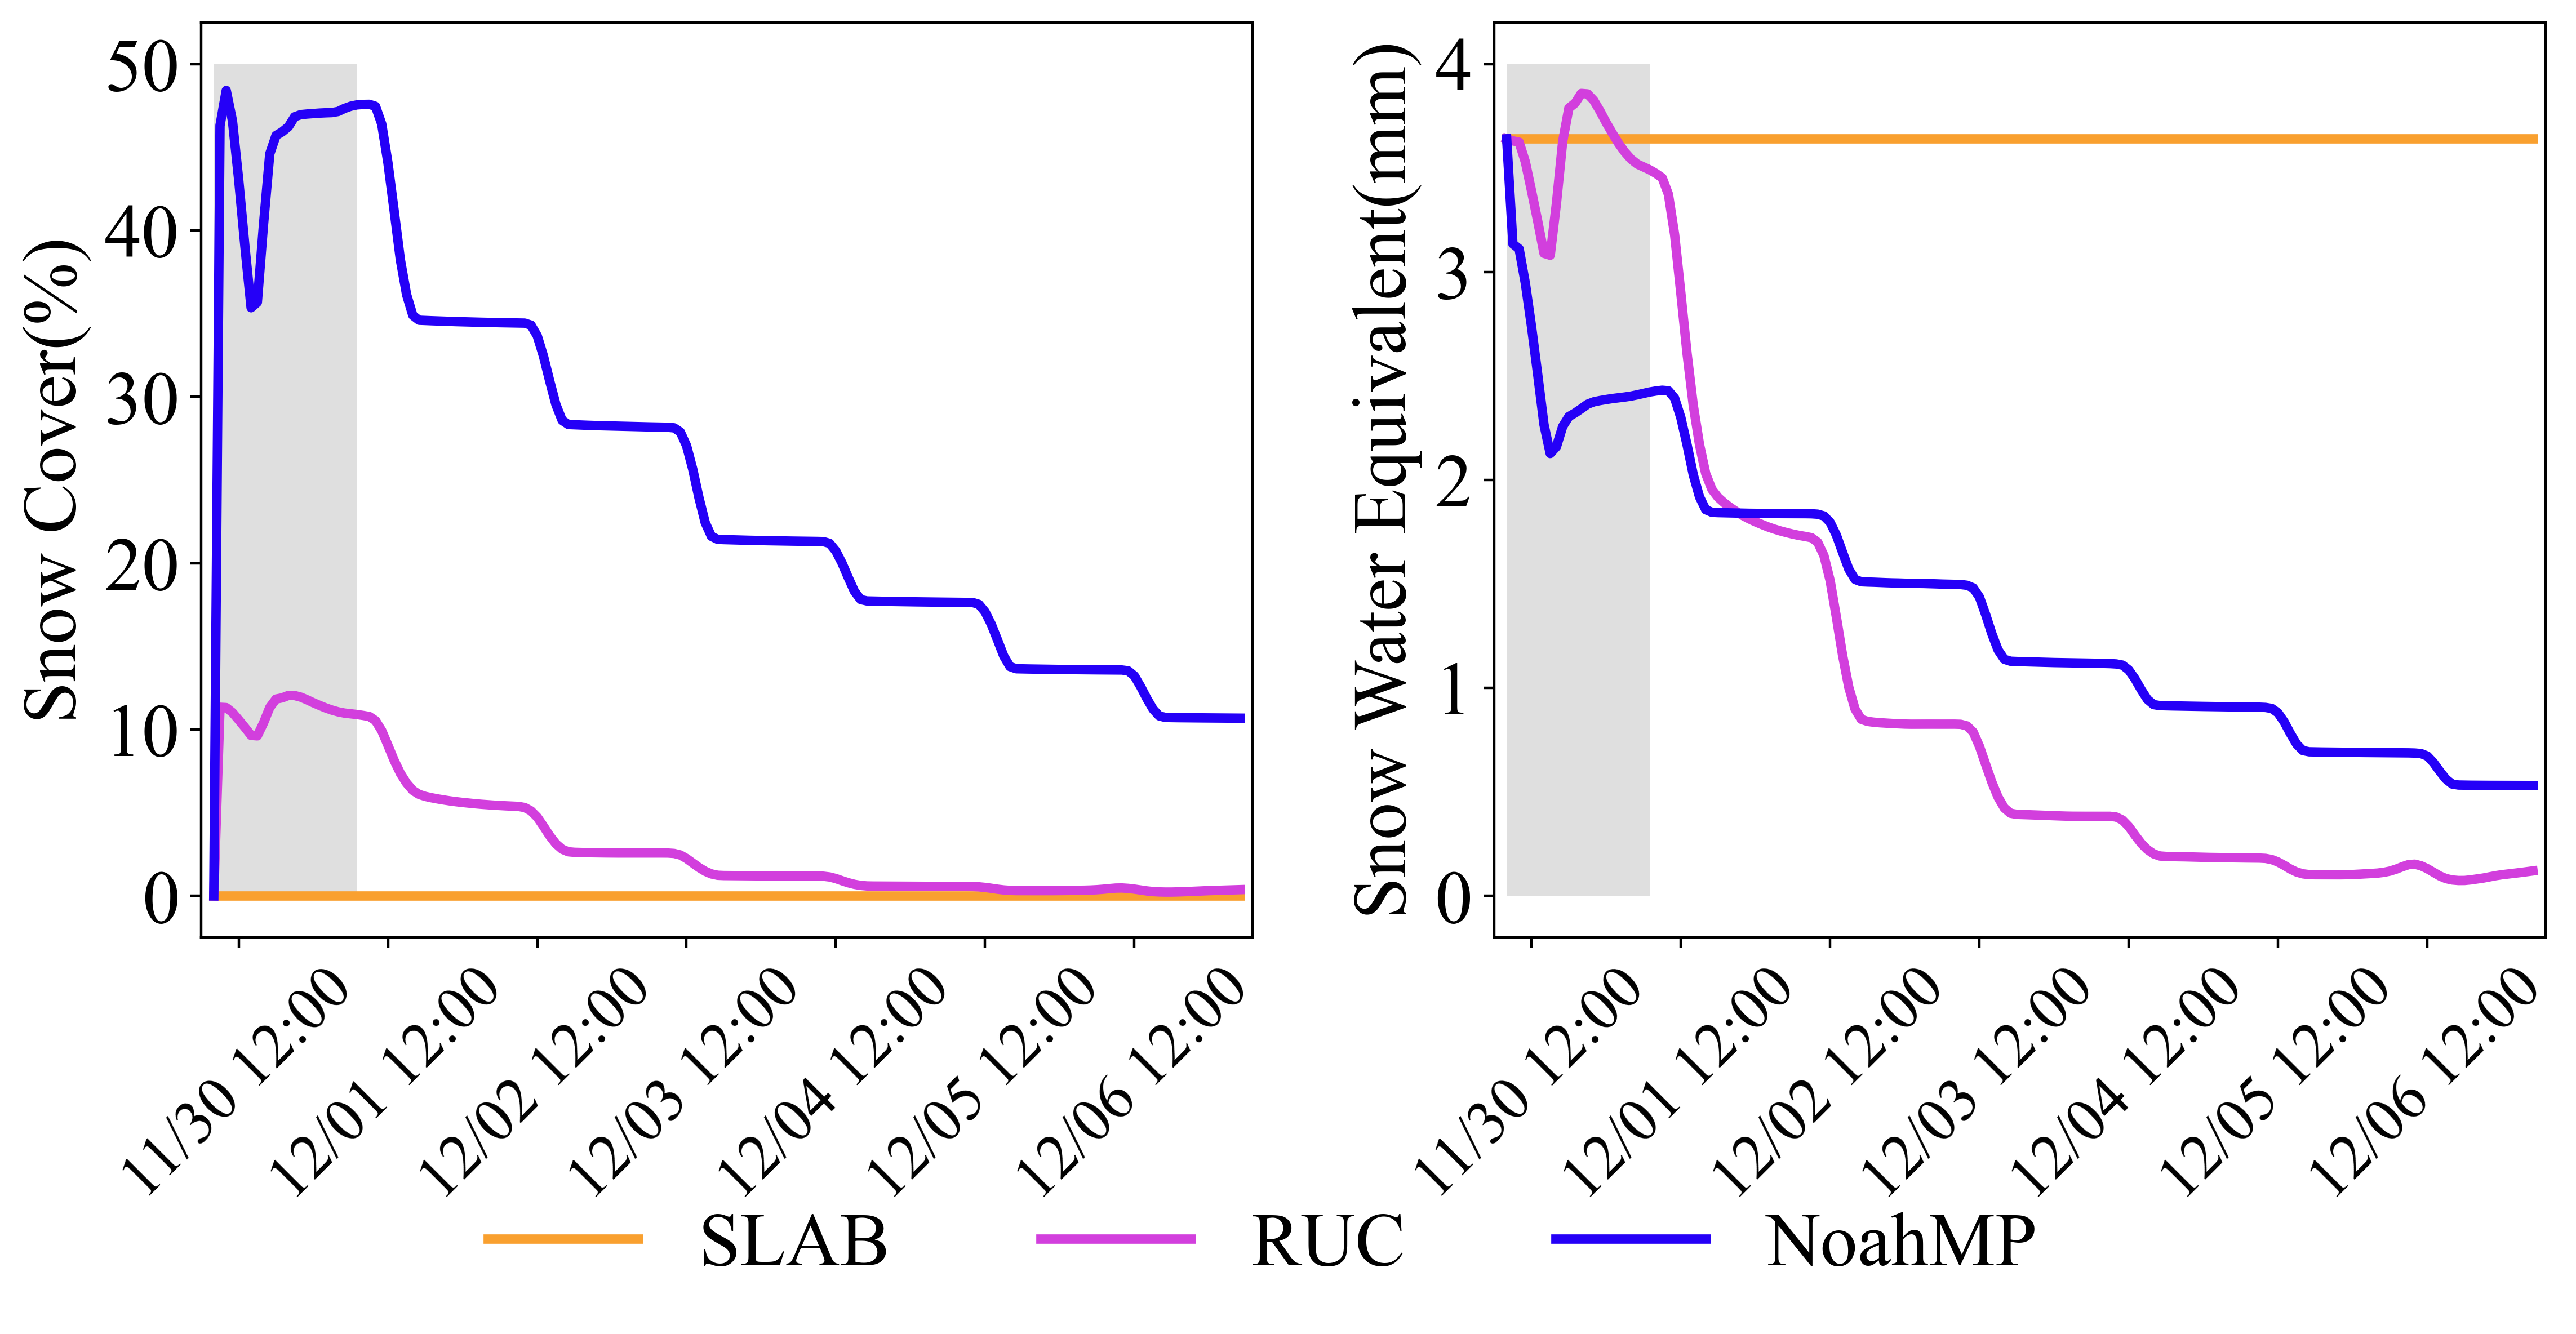

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
from matplotlib import rcParams

# 设置全局字体和字号
rcParams['font.family'] = 'Times New Roman'
rcParams['font.size'] = 24

# 导入NC文件（确保路径无中文）
nc_files = {
    'ruc': nc.Dataset("/Raid_38TB/wangying/zhouyy2023/WRF4.0_tianshui/WRF4.0/WRF/test/em_real_ruc_MYNN_LH/wrfout_d03_2019-11-30_00:00:00"),
    'slab': nc.Dataset("/Raid_38TB/wangying/zhouyy2023/WRF4.0_tianshui/WRF4.0/WRF/test/em_real_slab_MYNN_LH/wrfout_d03_2019-11-30_00:00:00"),
    'noahmp': nc.Dataset('/Raid_38TB/wangying/zhouyy2023/WRF4.0_tianshui/WRF4.0/WRF/test/em_real_noahmp_MYNN_LH/wrfout_d03_2019-11-30_00:00:00')
}

# 生成时间序列并格式化
time_range = pd.date_range("20191130", "20191208", freq="H")
time_labels = time_range.strftime("%m/%d %H:00")[8:174]  # 直接格式化时间
x_vals = np.arange(166)  # 时间轴数值

def calculate_spatial_mean(nc_file, var_name, scale=1):
    """计算指定变量的空间平均值"""
    results = []
    for t in range(166):
        # 使用NumPy直接计算平均值
        spatial_mean = np.mean(nc_file.variables[var_name][t]) * scale
        results.append(spatial_mean)
    return results

# 计算雪水当量（SNOW）
snow_data = {
    'SLAB': calculate_spatial_mean(nc_files['slab'], 'SNOW'),
    'RUC': calculate_spatial_mean(nc_files['ruc'], 'SNOW'),
    'NoahMP': calculate_spatial_mean(nc_files['noahmp'], 'SNOW')
}

# 计算雪覆盖率（SNOWC，转换为百分比）
snowc_data = {
    'SLAB': calculate_spatial_mean(nc_files['slab'], 'SNOWC', scale=100),
    'RUC': calculate_spatial_mean(nc_files['ruc'], 'SNOWC', scale=100),
    'NoahMP': calculate_spatial_mean(nc_files['noahmp'], 'SNOWC', scale=100)
}

# 创建图形和子图
fig, axes = plt.subplots(1, 2, figsize=(12, 6), dpi=400)
titles = ['Snow Cover(%)', 'Snow Water Equivalent(mm)']
colors = {'SLAB': '#f9a02f', 'RUC': '#d23fdd', 'NoahMP': '#2500f7'}

for ax, data, title in zip(axes, [snowc_data, snow_data], titles):
    # 绘制三条曲线
    for model, values in data.items():
        ax.plot(x_vals, values, '-', color=colors[model], alpha=1, linewidth=3, label=model)
    
    # 设置公共属性
    ax.set_xlim(-2, 167)
    ax.set_xticks(x_vals[4::24])
    ax.set_xticklabels(time_labels[4::24], rotation=45, fontsize=20)
    ax.set_ylabel(title)
    
    # 添加灰色背景区域（前24小时）
    ax.fill_between(x_vals[:24], 0, [50, 4][title.startswith('Snow Water')], 
                    alpha=0.25, facecolor='gray')

# 添加统一图例
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, frameon=False, 
           bbox_to_anchor=(0.8, 0.11), ncol=3)

plt.tight_layout()
#plt.savefig('snow_tianshui.jpg')
plt.show()

## Figure 8

/Raid_38TB/wangying/anaconda3/envs/env/lib/python3.12/site-packages/osgeo/osr.py:410: FutureWarning: Neither osr.UseExceptions() nor osr.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


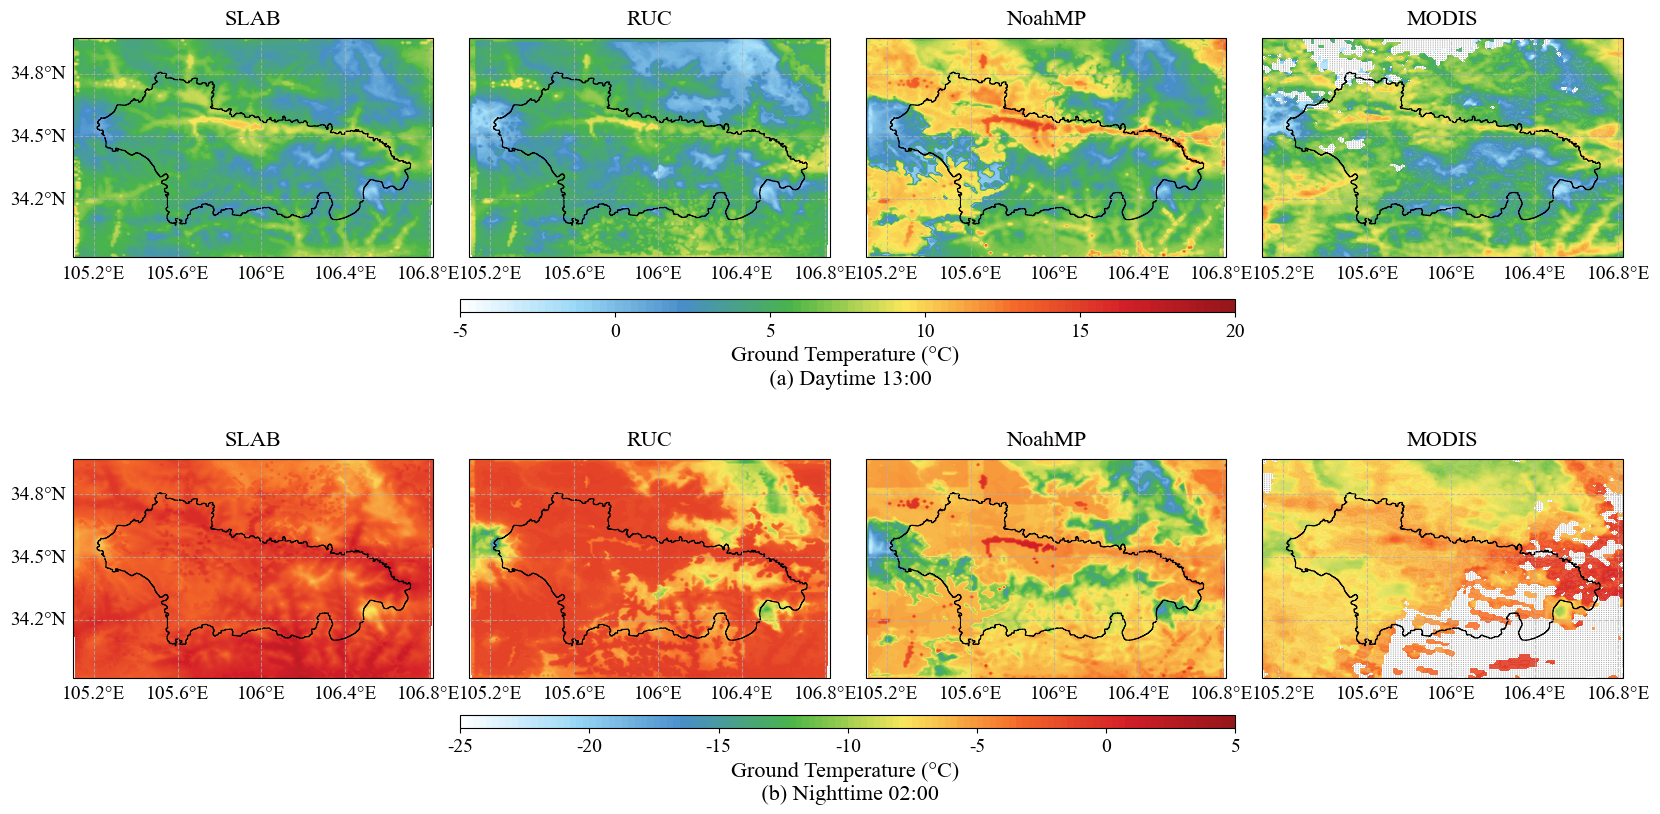

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmaps
from datetime import datetime, timedelta
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator
from osgeo import gdal, osr
import glob
from pyproj import Transformer
from scipy.interpolate import griddata

# 设置字体
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman', 'SimSun']  # 英文新罗马
plt.rcParams['axes.unicode_minus'] = False

# --------------------------- WRF数据处理部分 ---------------------------
nc_files = {
    "SLAB": nc.Dataset("/Raid_38TB/wangying/zhouyy2023/WRF4.0_tianshui/WRF4.0/WRF/test/em_real_slab_MYNN_LH/wrfout_d03_2019-11-30_00:00:00"),
    "RUC": nc.Dataset("/Raid_38TB/wangying/zhouyy2023/WRF4.0_tianshui/WRF4.0/WRF/test/em_real_ruc_MYNN_LH/wrfout_d03_2019-11-30_00:00:00"),
    "NoahMP": nc.Dataset('/Raid_38TB/wangying/zhouyy2023/WRF4.0_tianshui/WRF4.0/WRF/test/em_real_noahmp_MYNN_LH/wrfout_d03_2019-11-30_00:00:00')
}

tianshui = Reader('/Raid_38TB/wangying/zhouyy2023/notebook_directory/Tianshui_geo/z.shp')

def get_valid_indices(nc_file, hour_beijing):
    hour_utc = (hour_beijing - 8) % 24
    time_var = nc_file.variables['Times']
    base_time = datetime.strptime(time_var[0].tobytes().decode('utf-8'), '%Y-%m-%d_%H:%M:%S')
    valid_indices = []
    
    for idx in range(len(time_var)):
        current_time = base_time + timedelta(hours=idx)
        if current_time.month == 12 and 1 <= current_time.day <= 6:
            if current_time.hour == hour_utc:
                valid_indices.append(idx)
    return valid_indices

def calculate_avg_tsk(scheme_name, hour_beijing):
    nc_file = nc_files[scheme_name]
    indices = get_valid_indices(nc_file, hour_beijing)
    
    tsk_sum = np.zeros_like(nc_file.variables['TSK'][0,:,:])
    for i in indices:
        tsk_sum += nc_file.variables['TSK'][i,:,:]
    return (tsk_sum / len(indices)) - 273.15

# 计算WRF数据
data = {}
for scheme in ["SLAB", "RUC", "NoahMP"]:
    data[f"{scheme}_02"] = calculate_avg_tsk(scheme, 2)
    data[f"{scheme}_13"] = calculate_avg_tsk(scheme, 13)

# 获取WRF网格信息
wrf_lon = nc_files["SLAB"].variables['XLONG'][0,:,:]
wrf_lat = nc_files["SLAB"].variables['XLAT'][0,:,:]
lon_min, lon_max = np.min(wrf_lon), np.max(wrf_lon)
lat_min, lat_max = np.min(wrf_lat), np.max(wrf_lat)

# --------------------------- MODIS数据处理优化部分 ---------------------------
def decode_qc(qc_data):
    """优化后的质量控制解析"""
    qc_mask = np.full(qc_data.shape, False)
    for i in range(qc_data.shape[0]):
        for j in range(qc_data.shape[1]):
            qc_byte = qc_data[i, j]
            mandatory_qa = qc_byte & 0b00000011
            data_quality = (qc_byte & 0b00001100) >> 2
            qc_mask[i, j] = (mandatory_qa <= 1) and (data_quality <= 2)
    return qc_mask

def process_modis_data():
    # 坐标系转换
    src_srs = osr.SpatialReference()
    src_srs.ImportFromProj4("+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +R=6371007.181 +units=m +no_defs")
    transformer = Transformer.from_crs(src_srs.ExportToProj4(), "EPSG:4326", always_xy=True)

    # 时间过滤（只处理12月1-6日数据）
    modis_files = []
    for f in glob.glob("/Raid_38TB/wangying/zhouyy2023/DATA/MYD11A1/MYD11A1*.hdf"):
        date_str = f.split(".")[1][1:]  # 提取A2019365中的日期部分
        year = int(date_str[0:4])
        doy = int(date_str[4:7])
        date = datetime(year, 1, 1) + timedelta(doy-1)
        if date.month == 12 and 1 <= date.day <= 6:
            modis_files.append(f)

    # 数据累积器
    day_accum = night_accum = None
    count_day = count_night = None
    all_lons = []
    all_lats = []

    for file_path in modis_files:
        try:
            ds = gdal.Open(file_path)
            subdatasets = ds.GetSubDatasets()
            
            # 数据读取函数
            def process_subdataset(sub_type):
                data_ds = [s[0] for s in subdatasets if sub_type in s[0]][0]
                qc_ds = [s[0] for s in subdatasets if f"QC_{sub_type}" in s[0]][0]
                
                # 读取数据
                data = gdal.Open(data_ds).ReadAsArray() * 0.02
                data[data == 0] = np.nan
                
                # 质量控制
                qc_data = gdal.Open(qc_ds).ReadAsArray()
                data[~decode_qc(qc_data)] = np.nan
                
                # 坐标转换
                gt = gdal.Open(data_ds).GetGeoTransform()
                x = np.arange(gt[0], gt[0]+gt[1]*data.shape[1], gt[1])
                y = np.arange(gt[3], gt[3]+gt[5]*data.shape[0], gt[5])
                xx, yy = np.meshgrid(x, y)
                lon, lat = transformer.transform(xx, yy)
                
                return data, lon, lat

            # 处理日间和夜间数据
            day_data, day_lon, day_lat = process_subdataset("Day")
            night_data, night_lon, night_lat = process_subdataset("Night")
            
            # 累积数据
            if day_accum is None:
                day_accum = np.zeros_like(day_data)
                night_accum = np.zeros_like(night_data)
                count_day = np.zeros_like(day_data, dtype=int)
                count_night = np.zeros_like(night_data, dtype=int)
                all_lons = day_lon
                all_lats = day_lat
            
            valid_day = ~np.isnan(day_data)
            day_accum[valid_day] += day_data[valid_day]
            count_day[valid_day] += 1
            
            valid_night = ~np.isnan(night_data)
            night_accum[valid_night] += night_data[valid_night]
            count_night[valid_night] += 1

        except Exception as e:
            print(f"处理文件{file_path}时出错: {str(e)}")

    # 计算平均值
    with np.errstate(divide='ignore', invalid='ignore'):
        modis_day = (day_accum / count_day) - 273.15
        modis_night = (night_accum / count_night) - 273.15

    # 空间插值到WRF网格
    grid_x, grid_y = wrf_lon.shape[1], wrf_lon.shape[0]
    grid_lon = np.linspace(lon_min, lon_max, grid_x)
    grid_lat = np.linspace(lat_min, lat_max, grid_y)
    grid_xx, grid_yy = np.meshgrid(grid_lon, grid_lat)

    def interpolate_data(data, src_lon, src_lat):
        points = np.vstack([src_lon.ravel(), src_lat.ravel()]).T
        values = data.ravel()
        return griddata(points, values, (grid_xx, grid_yy), 
                       method='nearest', fill_value=np.nanmean(values))

    return (
        interpolate_data(modis_day, all_lons, all_lats),
        interpolate_data(modis_night, all_lons, all_lats),
        grid_xx, 
        grid_yy
    )

# 执行MODIS数据处理
modis_day, modis_night, modis_lon, modis_lat = process_modis_data()

# --------------------------- 可视化部分（修改后） ---------------------------
# 设置不同的色条范围（保持1度间隔）
levels_day = np.linspace(-5, 20, 101)   # 上排：-5~20℃
levels_night = np.linspace(-25, 5, 121) # 下排：-25~5℃

# 创建每5度一个的刻度位置（用于色条标签）
ticks_day = np.arange(-5, 21, 5)    # -5, 0, 5, 10, 15, 20
ticks_night = np.arange(-25, 6, 5)  # -25, -20, -15, -10, -5, 0, 5

# 使用指定的色条颜色
cmap = cmaps.WhiteBlueGreenYellowRed
proj = ccrs.PlateCarree()

# 创建2行4列的子图布局
fig, axes = plt.subplots(2, 4, figsize=(20, 10), subplot_kw={'projection': proj})
plt.subplots_adjust(wspace=0.1, hspace=0.17)

def plot_subplot(ax, data, title, levels, is_modis=False):
    # 统一绘图参数 
    plot_params = {
        'levels': levels,
        'cmap': cmap,
        'extend': 'neither', 
        'transform': proj,
        'alpha': 0.9 if is_modis else 1.0
    }
    
    if is_modis:
        contour = ax.contourf(modis_lon, modis_lat, data, **plot_params)
    else:
        contour = ax.contourf(wrf_lon, wrf_lat, data, **plot_params)
    
    # 添加地理要素
    ax.add_geometries(tianshui.geometries(), crs=proj, 
                     edgecolor='k', facecolor='none', lw=0.8)
    ax.coastlines(resolution='10m', linewidth=0.6)
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=proj)
    
    # 设置网格线
    gl = ax.gridlines(draw_labels=True, linestyle='--', alpha=0.7)
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    
    # 修复部分：使用标准方法判断子图位置
    # 获取子图在网格中的行列位置
    rows, cols = ax.get_subplotspec().get_gridspec().get_geometry()
    row_idx, col_idx = ax.get_subplotspec().rowspan.start, ax.get_subplotspec().colspan.start
    
    # 只在左侧子图添加y轴标签
    gl.left_labels = (col_idx == 0)  # 第一列显示标签

    # ============== 设置刻度数量和字体大小 ==============
    # 设置刻度数量
    gl.xlocator = MaxNLocator(nbins=5)  # x轴只显示5个刻度
    gl.ylocator = MaxNLocator(nbins=4)  # y轴只显示4个刻度
        
    # 设置刻度标签字体大小
    gl.xlabel_style = {'size': 14}  # 增大x轴刻度标签字体
    gl.ylabel_style = {'size': 14}  # 增大y轴刻度标签字体

    ax.set_title(title, fontsize=16, pad=10)
    
    # 专门为卫星数据添加缺失值标记（每个缺失值都画）
    if is_modis:
        # 创建缺失值掩码
        missing_mask = np.isnan(data)
        
        # 获取所有缺失值的坐标
        missing_lon = modis_lon[missing_mask]
        missing_lat = modis_lat[missing_mask]
        
        # 绘制灰色小圆点标记缺失值（点更小，s=0.5）
        ax.scatter(missing_lon, missing_lat, s=0.5, color='gray', 
                   alpha=0.9, transform=proj, marker='o', 
                   edgecolors='none')
    
    return contour

# 定义子图布局和标题
plot_config = [
    # 上排（使用levels_day）
    (0, 0, "SLAB_13", "SLAB", levels_day),
    (0, 1, "RUC_13", "RUC", levels_day),
    (0, 2, "NoahMP_13", "NoahMP", levels_day),
    (0, 3, modis_day, "MODIS", levels_day, True),
    
    # 下排（使用levels_night）
    (1, 0, "SLAB_02", "SLAB", levels_night),
    (1, 1, "RUC_02", "RUC", levels_night),
    (1, 2, "NoahMP_02", "NoahMP", levels_night),
    (1, 3, modis_night, "MODIS", levels_night, True)
]

contours_day = []  # 收集上排的contour对象
contours_night = []  # 收集下排的contour对象

for config in plot_config:
    row, col, data_key, title, levels = config[:5]
    is_modis = len(config) > 5
    
    if is_modis:
        c = plot_subplot(axes[row, col], data_key, title, levels, True)
    else:
        c = plot_subplot(axes[row, col], data[data_key], title, levels)
    
    # 根据行收集contour对象
    if row == 0:
        contours_day.append(c)
    else:
        contours_night.append(c)

# 添加上排色条（放在上排下方）
cbar_day = fig.colorbar(contours_day[0], ax=axes[0, :], orientation='horizontal',
                       pad=0.9, aspect=60, shrink=0.5)
cbar_day.set_label('Ground Temperature (°C) \n (a) Daytime 13:00', fontsize=16)

# 设置日间色条的刻度位置（每5度一个标签）
cbar_day.set_ticks(ticks_day)

cbar_day.ax.tick_params(labelsize=14)  # 增大色条刻度标签字体

# 添加下排色条（放在下排下方）
cbar_night = fig.colorbar(contours_night[0], ax=axes[1, :], orientation='horizontal',
                         pad=0.15, aspect=60, shrink=0.5)
cbar_night.set_label('Ground Temperature (°C) \n (b) Nighttime 02:00', fontsize=16)

# 设置夜间色条的刻度位置（每5度一个标签）
cbar_night.set_ticks(ticks_night)

cbar_night.ax.tick_params(labelsize=14)  # 增大色条刻度标签字体

# 调整布局，为色条留出空间
plt.subplots_adjust(bottom=0.20, top=0.98)

# 保存结果
#plt.savefig('WRF_MODIS_Comparison_2x4_with_separate_colorbar.png', dpi=300, bbox_inches='tight')
plt.show()